# 323 Group Assignment: Group 2
# Facial Expression Recognition

## Goal: Train 3 models on the FER2013 Dataset (~30+k monochromatic images) to demonstrate difference in accuracy, through increasing complexity of CNN models.

Lai Wei Jie (UOW: 7770042)


Farah nurliyana bte roseley (UOW: 8377443)


Ivan Yong Sheng, Tan (UOW: 8750099)


Nila Kandasamy Rajamohan (UOW: 8433252)


Wasilah Mumina (UOW: 8434463)



In [ ]:
import torch
print(torch.__version__)


2.2.2


In [ ]:
import torch

# Check if CUDA is available
if torch.cuda.is_available():
    print(f"CUDA is available. GPU: {torch.cuda.get_device_name(0)}")
else:
    print("CUDA is not available.")


CUDA is available. GPU: NVIDIA GeForce RTX 4050 Laptop GPU


Code for loading dataset through google drive

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

In [ ]:
# import zipfile
# import os

# # Copy the zip file from Google Drive to Colab environment
# !cp /content/drive/MyDrive/FER2013.zip /content/

# # Unzip the file
# with zipfile.ZipFile('/content/FER2013.zip', 'r') as zip_ref:
#     zip_ref.extractall('/content/FER2013')

# # Verify the contents of the extracted folder
# !ls /content/FER2013

### FER2013 Dataset obtained from: https://www.kaggle.com/datasets/msambare/fer2013


### Import libraries

In [ ]:
# Import necessary libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch.nn.functional as F
from sklearn.metrics import precision_recall_fscore_support, accuracy_score

### Load and transform datasets

Code for loading data locally

In [ ]:
train_path = "C:\\Users\\laiwe\\Downloads\\FER2013\\train"

test_path ="C:\\Users\\laiwe\\Downloads\\FER2013\\test"

In [ ]:
# Define transformations for the training and test datasets
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),  # Convert images to grayscale
    transforms.Resize((48, 48)),  # Resize images to 48x48 pixels
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))  # Normalize images
])

# Local
# Load datasets
train_dataset = datasets.ImageFolder(root=train_path, transform=transform)
test_dataset = datasets.ImageFolder(root=test_path, transform=transform)

# Colab
# train_dataset = datasets.ImageFolder(root='/content/FER2013/FER2013/train', transform=transform)
# test_dataset = datasets.ImageFolder(root='/content/FER2013/FER2013/test', transform=transform)

train_loader = DataLoader(dataset=train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=32, shuffle=False)

In [ ]:
print(f'Size of training dataset: {len(train_dataset)}')
print(f'Size of test dataset: {len(test_dataset)}')

Size of training dataset: 28709
Size of test dataset: 7178


In [ ]:
from collections import Counter

# Get the distribution of classes in the training dataset
class_counts = Counter(train_dataset.targets)

# Get the mapping of indices to class names
class_names = train_dataset.classes

# Print the size of each class with class names
for class_idx, count in class_counts.items():
    print(f'Class: {class_names[class_idx]}, Count: {count}')

Class: angry, Count: 3995
Class: disgust, Count: 436
Class: fear, Count: 4097
Class: happy, Count: 7215
Class: neutral, Count: 4965
Class: sad, Count: 4830
Class: surprise, Count: 3171


In [ ]:
# Get the distribution of classes in the test dataset
class_counts_test = Counter(test_dataset.targets)

# Get the mapping of indices to class names
class_names_test = test_dataset.classes

# Print the size of each class with class names
for class_idx, count in class_counts_test.items():
    print(f'Class: {class_names_test[class_idx]}, Count: {count}')

Class: angry, Count: 958
Class: disgust, Count: 111
Class: fear, Count: 1024
Class: happy, Count: 1774
Class: neutral, Count: 1233
Class: sad, Count: 1247
Class: surprise, Count: 831


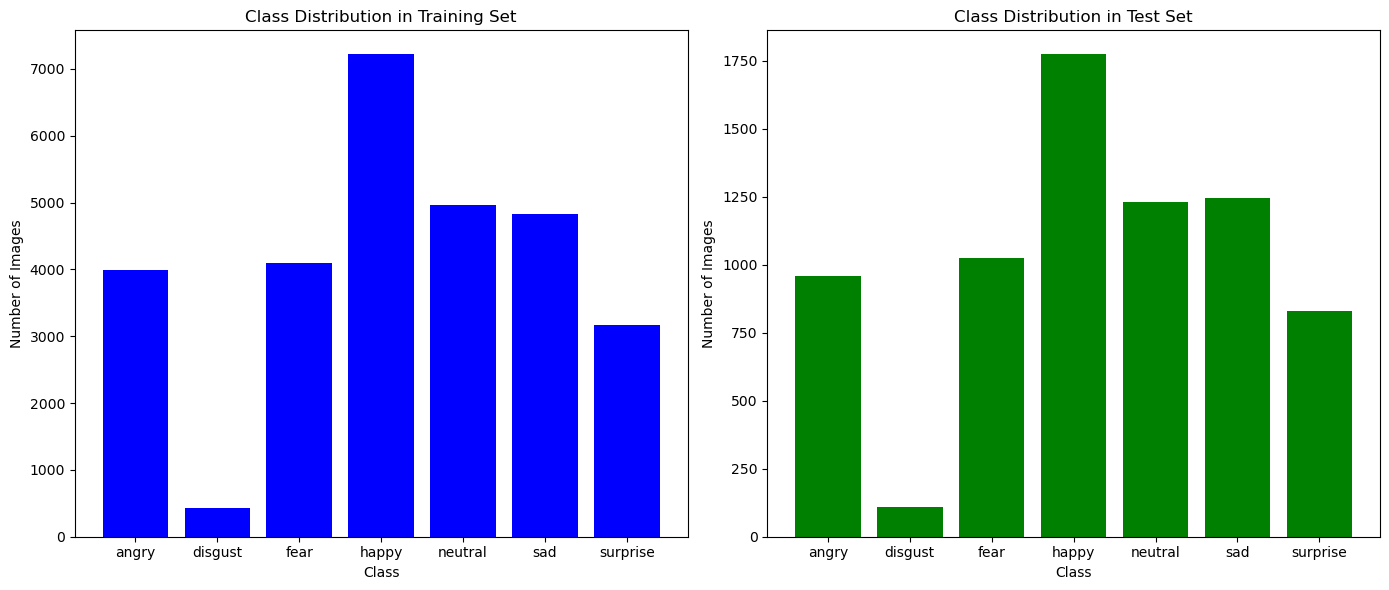

In [ ]:
import os
import matplotlib.pyplot as plt
from collections import Counter

# Function to count images in each class
def count_classes(directory):
    class_counts = Counter()
    for root, dirs, files in os.walk(directory):
        if len(files) > 0:
            class_name = os.path.basename(root)
            class_counts[class_name] += len([file for file in files if file.endswith(('png', 'jpg', 'jpeg'))])
    return class_counts

# Get the class counts for train and test sets
train_class_counts = count_classes(train_path)
test_class_counts = count_classes(test_path)

# Plotting the histogram for train set
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plt.bar(train_class_counts.keys(), train_class_counts.values(), color='blue')
plt.title('Class Distribution in Training Set')
plt.xlabel('Class')
plt.ylabel('Number of Images')

# Plotting the histogram for test set
plt.subplot(1, 2, 2)
plt.bar(test_class_counts.keys(), test_class_counts.values(), color='green')
plt.title('Class Distribution in Test Set')
plt.xlabel('Class')
plt.ylabel('Number of Images')

plt.tight_layout()
plt.show()

### Define model, loss function and optimizer

In [ ]:
# Define a simple CNN model
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.fc1 = nn.Linear(128 * 6 * 6, 512)
        self.fc2 = nn.Linear(512, 7)  # Assuming 7 emotion classes

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(-1, 128 * 6 * 6)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Instantiate the model, define the loss function and optimizer
model = SimpleCNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [ ]:
# Training function
def train(model, loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    for inputs, labels in loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)

    epoch_loss = running_loss / len(loader.dataset)
    return epoch_loss

In [ ]:
# Evaluation function
def evaluate(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0
    corrects = 0
    all_labels = []
    all_preds = []
    class_corrects = [0] * len(train_dataset.classes)
    class_totals = [0] * len(train_dataset.classes)

    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * inputs.size(0)

            _, preds = torch.max(outputs, 1)
            corrects += torch.sum(preds == labels.data)

            for i in range(len(labels)):
                label = labels[i].item()
                pred = preds[i].item()
                if label == pred:
                    class_corrects[label] += 1
                class_totals[label] += 1

            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())

    epoch_loss = running_loss / len(loader.dataset)
    accuracy = corrects.double() / len(loader.dataset)
    precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average='weighted')
    class_accuracies = [class_corrects[i] / class_totals[i] if class_totals[i] > 0 else 0 for i in range(len(train_dataset.classes))]
    return epoch_loss, accuracy, precision, recall, f1, class_accuracies

### Training and evaluation

In [ ]:
# Main training loop
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

num_epochs = 10
for epoch in range(num_epochs):
    train_loss = train(model, train_loader, criterion, optimizer, device)
    print(f'Epoch {epoch+1}/{num_epochs} - Train Loss: {train_loss:.4f}')

# Evaluate the model after the last epoch
val_loss, val_accuracy, precision, recall, f1, class_accuracies = evaluate(model, test_loader, criterion, device)

print(f'Validation Loss: {val_loss:.4f}, Overall Accuracy: {val_accuracy:.4f}')
print(f'Precision: {precision:.4f}, Recall: {recall:.4f}, F1-score: {f1:.4f}')
for i, acc in enumerate(class_accuracies):
    print(f'Class {train_dataset.classes[i]} Accuracy: {acc:.4f}')

Epoch 1/10 - Train Loss: 1.5562
Epoch 2/10 - Train Loss: 1.3024
Epoch 3/10 - Train Loss: 1.1491
Epoch 4/10 - Train Loss: 1.0051
Epoch 5/10 - Train Loss: 0.8439
Epoch 6/10 - Train Loss: 0.6588
Epoch 7/10 - Train Loss: 0.4633
Epoch 8/10 - Train Loss: 0.3026
Epoch 9/10 - Train Loss: 0.1946
Epoch 10/10 - Train Loss: 0.1525
Validation Loss: 2.5628, Overall Accuracy: 0.5502
Precision: 0.5549, Recall: 0.5502, F1-score: 0.5513
Class angry Accuracy: 0.4447
Class disgust Accuracy: 0.5315
Class fear Accuracy: 0.4619
Class happy Accuracy: 0.7435
Class neutral Accuracy: 0.4461
Class sad Accuracy: 0.4010
Class surprise Accuracy: 0.7485


# Training ResNet18: Via Transfer Learning

In [ ]:
from torchvision import datasets, transforms, models

# Define transformations for the training and test datasets
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),  # Convert images to 3 channels
    transforms.Resize((224, 224)),  # Resize images to 224x224 pixels
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize images
])

# Local
# Load datasets
train_dataset = datasets.ImageFolder(root=train_path, transform=transform)
test_dataset = datasets.ImageFolder(root=test_path, transform=transform)


# # Load datasets
# train_dataset = datasets.ImageFolder(root='/content/FER2013/FER2013/train', transform=transform)
# test_dataset = datasets.ImageFolder(root='/content/FER2013/FER2013/test', transform=transform)

train_loader = DataLoader(dataset=train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=32, shuffle=False)

# Load the pre-trained ResNet18 model with the correct weights parameter
model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)

# Modify the final fully connected layer to match the number of classes (7 for FER2013)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 7)

# # Freeze the initial layers
# for param in model.features.parameters():
#     param.requires_grad = False

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Main training loop
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

num_epochs = 10
for epoch in range(num_epochs):
    train_loss = train(model, train_loader, criterion, optimizer, device)
    print(f'Epoch {epoch+1}/{num_epochs} - Train Loss: {train_loss:.4f}')

# Evaluate the model after the last epoch
val_loss, val_accuracy, precision, recall, f1, class_accuracies = evaluate(model, test_loader, criterion, device)

print(f'Validation Loss: {val_loss:.4f}, Overall Accuracy: {val_accuracy:.4f}')
print(f'Precision: {precision:.4f}, Recall: {recall:.4f}, F1-score: {f1:.4f}')
for i, acc in enumerate(class_accuracies):
    print(f'Class {train_dataset.classes[i]} Accuracy: {acc:.4f}')

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to C:\Users\laiwe/.cache\torch\hub\checkpoints\resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:01<00:00, 32.0MB/s]


Epoch 1/10 - Train Loss: 1.2617
Epoch 2/10 - Train Loss: 1.0652
Epoch 3/10 - Train Loss: 0.9574
Epoch 4/10 - Train Loss: 0.8442
Epoch 5/10 - Train Loss: 0.7135
Epoch 6/10 - Train Loss: 0.5353
Epoch 7/10 - Train Loss: 0.3602
Epoch 8/10 - Train Loss: 0.2404
Epoch 9/10 - Train Loss: 0.1765
Epoch 10/10 - Train Loss: 0.1326
Validation Loss: 1.8706, Overall Accuracy: 0.6184
Precision: 0.6224, Recall: 0.6184, F1-score: 0.6166
Class angry Accuracy: 0.5094
Class disgust Accuracy: 0.5405
Class fear Accuracy: 0.5732
Class happy Accuracy: 0.8613
Class neutral Accuracy: 0.4931
Class sad Accuracy: 0.4379
Class surprise Accuracy: 0.7485


# ResMaskingNet Model

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms, datasets
from torch.utils.data import DataLoader
from sklearn.metrics import precision_recall_fscore_support

# Importing the correct weights attribute
from torchvision.models import ResNet18_Weights

class ResMaskingNet(nn.Module):
    def __init__(self, num_classes=7):
        super(ResMaskingNet, self).__init__()
        # Load a pre-trained ResNet18 model with weights
        self.resnet = models.resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)
        # Modify the ResNet18 model to retain the spatial dimensions
        self.resnet.avgpool = nn.Identity()
        self.resnet.fc = nn.Identity()

        # Masking mechanism
        self.mask = nn.Sequential(
            nn.Conv2d(512, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 1, kernel_size=1),
            nn.Sigmoid()
        )

        # Fully connected layers
        self.fc = nn.Sequential(
            nn.Linear(512 * 7 * 7, 512),
            nn.ReLU(),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        # Extract features using ResNet
        x = self.resnet(x)

        # Reshape x to (batch_size, 512, 7, 7) before applying the masking mechanism
        x = x.view(x.size(0), 512, 7, 7)

        # Apply masking mechanism
        mask = self.mask(x)
        x = x * mask

        # Flatten and apply fully connected layers
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

# Instantiate the model
num_classes = 7
model = ResMaskingNet(num_classes=num_classes)

# Define transformations for the datasets
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),  # Convert images to 3 channels
    transforms.Resize((224, 224)),  # Resize images to 224x224 pixels
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize images
])

# Load datasets
train_dataset = datasets.ImageFolder(root=train_path, transform=transform)
test_dataset = datasets.ImageFolder(root=test_path, transform=transform)

train_loader = DataLoader(dataset=train_dataset, batch_size=32, shuffle=True, num_workers=4)
test_loader = DataLoader(dataset=test_dataset, batch_size=32, shuffle=False, num_workers=4)


# Define the loss function
criterion = nn.CrossEntropyLoss()

# Define the optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Function to train the model
def train(model, loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    for inputs, labels in loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)

    epoch_loss = running_loss / len(loader.dataset)
    return epoch_loss

# Function to evaluate the model
def evaluate(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0
    corrects = 0
    all_labels = []
    all_preds = []
    class_corrects = [0] * len(train_dataset.classes)
    class_totals = [0] * len(train_dataset.classes)

    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * inputs.size(0)

            _, preds = torch.max(outputs, 1)
            corrects += torch.sum(preds == labels.data)

            for i in range(len(labels)):
                label = labels[i].item()
                pred = preds[i].item()
                if label == pred:
                    class_corrects[label] += 1
                class_totals[label] += 1

            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())

    epoch_loss = running_loss / len(loader.dataset)
    accuracy = corrects.double() / len(loader.dataset)
    precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average='weighted')
    class_accuracies = [class_corrects[i] / class_totals[i] if class_totals[i] > 0 else 0 for i in range(len(train_dataset.classes))]
    return epoch_loss, accuracy, precision, recall, f1, class_accuracies

# Main training loop
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

num_epochs = 10
for epoch in range(num_epochs):
    train_loss = train(model, train_loader, criterion, optimizer, device)
    val_loss, val_accuracy, precision, recall, f1, class_accuracies = evaluate(model, test_loader, criterion, device)
    print(f'Epoch {epoch+1}/{num_epochs} - Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}')

# Evaluate the model after the last epoch with detailed metrics
val_loss, val_accuracy, precision, recall, f1, class_accuracies = evaluate(model, test_loader, criterion, device)

print(f'Validation Loss: {val_loss:.4f}, Overall Accuracy: {val_accuracy:.4f}')
print(f'Precision: {precision:.4f}, Recall: {recall:.4f}, F1-score: {f1:.4f}')
for i, acc in enumerate(class_accuracies):
    print(f'Class {train_dataset.classes[i]} Accuracy: {acc:.4f}')


Epoch 1/10 - Train Loss: 1.3823, Validation Loss: 1.2182, Validation Accuracy: 0.5327
Epoch 2/10 - Train Loss: 1.0703, Validation Loss: 1.1293, Validation Accuracy: 0.5658
Epoch 3/10 - Train Loss: 0.9437, Validation Loss: 1.0421, Validation Accuracy: 0.6162
Epoch 4/10 - Train Loss: 0.8149, Validation Loss: 1.1208, Validation Accuracy: 0.5992
Epoch 5/10 - Train Loss: 0.6463, Validation Loss: 1.0953, Validation Accuracy: 0.6198
Epoch 6/10 - Train Loss: 0.4487, Validation Loss: 1.2468, Validation Accuracy: 0.6279
Epoch 7/10 - Train Loss: 0.2893, Validation Loss: 1.4656, Validation Accuracy: 0.6202
Epoch 8/10 - Train Loss: 0.1891, Validation Loss: 1.7406, Validation Accuracy: 0.6360
Epoch 9/10 - Train Loss: 0.1503, Validation Loss: 1.7222, Validation Accuracy: 0.6236
Epoch 10/10 - Train Loss: 0.1206, Validation Loss: 1.8194, Validation Accuracy: 0.6268
Validation Loss: 1.8194, Overall Accuracy: 0.6268
Precision: 0.6309, Recall: 0.6268, F1-score: 0.6270
Class angry Accuracy: 0.4562
Class di

# DenseNet 121

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms, datasets
from torch.utils.data import DataLoader
from sklearn.metrics import precision_recall_fscore_support

# Define the paths
train_path = "C:\\Users\\laiwe\\Downloads\\FER2013\\train"
test_path = "C:\\Users\\laiwe\\Downloads\\FER2013\\test"

# Define transformations for the datasets
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),  # Convert images to 3 channels
    transforms.Resize((224, 224)),  # Resize images to 224x224 pixels
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize images
])

# Load datasets
train_dataset = datasets.ImageFolder(root=train_path, transform=transform)
test_dataset = datasets.ImageFolder(root=test_path, transform=transform)

train_loader = DataLoader(dataset=train_dataset, batch_size=32, shuffle=True, num_workers=4)
test_loader = DataLoader(dataset=test_dataset, batch_size=32, shuffle=False, num_workers=4)

# Load the pre-trained DenseNet model
model = models.densenet121(weights=models.DenseNet121_Weights.IMAGENET1K_V1)

# Modify the final layer to match the number of classes in FER2013 (7 classes)
model.classifier = nn.Linear(model.classifier.in_features, 7)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Function to train the model
def train(model, loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    for inputs, labels in loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)

    epoch_loss = running_loss / len(loader.dataset)
    return epoch_loss

# Function to evaluate the model
def evaluate(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0
    corrects = 0
    all_labels = []
    all_preds = []
    class_corrects = [0] * len(train_dataset.classes)
    class_totals = [0] * len(train_dataset.classes)

    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * inputs.size(0)

            _, preds = torch.max(outputs, 1)
            corrects += torch.sum(preds == labels.data)

            for i in range(len(labels)):
                label = labels[i].item()
                pred = preds[i].item()
                if label == pred:
                    class_corrects[label] += 1
                class_totals[label] += 1

            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())

    epoch_loss = running_loss / len(loader.dataset)
    accuracy = corrects.double() / len(loader.dataset)
    precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average='weighted')
    class_accuracies = [class_corrects[i] / class_totals[i] if class_totals[i] > 0 else 0 for i in range(len(train_dataset.classes))]
    return epoch_loss, accuracy, precision, recall, f1, class_accuracies

# Main training loop
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

num_epochs = 10
for epoch in range(num_epochs):
    train_loss = train(model, train_loader, criterion, optimizer, device)
    val_loss, val_accuracy, precision, recall, f1, class_accuracies = evaluate(model, test_loader, criterion, device)
    print(f'Epoch {epoch+1}/{num_epochs} - Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}')

# Evaluate the model after the last epoch with detailed metrics
val_loss, val_accuracy, precision, recall, f1, class_accuracies = evaluate(model, test_loader, criterion, device)

print(f'Validation Loss: {val_loss:.4f}, Overall Accuracy: {val_accuracy:.4f}')
print(f'Precision: {precision:.4f}, Recall: {recall:.4f}, F1-score: {f1:.4f}')
for i, acc in enumerate(class_accuracies):
    print(f'Class {train_dataset.classes[i]} Accuracy: {acc:.4f}')


Epoch 1/10 - Train Loss: 1.2690, Validation Loss: 1.1545, Validation Accuracy: 0.5585
Epoch 2/10 - Train Loss: 1.0867, Validation Loss: 1.0738, Validation Accuracy: 0.6006
Epoch 3/10 - Train Loss: 1.0101, Validation Loss: 1.0265, Validation Accuracy: 0.6240
Epoch 4/10 - Train Loss: 0.9425, Validation Loss: 1.1144, Validation Accuracy: 0.5984
Epoch 5/10 - Train Loss: 0.8913, Validation Loss: 1.0706, Validation Accuracy: 0.6193
Epoch 6/10 - Train Loss: 0.8292, Validation Loss: 1.0471, Validation Accuracy: 0.6223
Epoch 7/10 - Train Loss: 0.7630, Validation Loss: 1.0433, Validation Accuracy: 0.6375
Epoch 8/10 - Train Loss: 0.6893, Validation Loss: 0.9901, Validation Accuracy: 0.6558
Epoch 9/10 - Train Loss: 0.6019, Validation Loss: 1.0247, Validation Accuracy: 0.6470
Epoch 10/10 - Train Loss: 0.5129, Validation Loss: 1.1418, Validation Accuracy: 0.6484
Validation Loss: 1.1418, Overall Accuracy: 0.6484
Precision: 0.6538, Recall: 0.6484, F1-score: 0.6458
Class angry Accuracy: 0.6681
Class di

DenseNet
DenseNet (Densely Connected Convolutional Networks) was introduced by Gao Huang et al. in the paper "Densely Connected Convolutional Networks". DenseNet is known for its distinctive architecture, which connects each layer to every other layer in a feed-forward fashion. This connectivity pattern results in efficient feature reuse and reduces the number of parameters needed.

Architecture
Dense Blocks:

A Dense Block consists of multiple layers, where each layer receives inputs from all preceding layers. The output feature maps of each layer are concatenated with the inputs of the subsequent layer.
This dense connectivity encourages feature reuse and reduces the risk of vanishing gradients, as the gradient can flow through many shorter connections.
Transition Layers:

Between two contiguous dense blocks, there are transition layers that perform convolution and pooling. These layers help to control the complexity and reduce the size of the feature maps.
Key Characteristics
Dense Connections:

Each layer has direct access to the gradients from the loss function and the original input signal, leading to improved gradient flow and better training efficiency.
Parameter Efficiency:

DenseNet is more parameter-efficient compared to traditional CNNs like VGG, as it uses concatenation of feature maps, which reduces the number of parameters while maintaining or improving performance.
Depth:

DenseNet can be very deep. Common variants include DenseNet-121, DenseNet-169, DenseNet-201, and DenseNet-264, where the numbers indicate the depth of the network.
Performance:

DenseNet achieves high performance on image classification benchmarks like CIFAR-10, CIFAR-100, and ImageNet, often outperforming ResNet while using fewer parameters.

# Saving the Trained DenseNet Model and testing on a new live photo

In [ ]:
# Save the trained model
torch.save(model.state_dict(), 'densenet121_fer2013.pth')

Load the saved model and set to evaluation mode

In [1]:
import torch
import torch.nn as nn
from torchvision import models, transforms
from PIL import Image
import matplotlib.pyplot as plt

# Define the model architecture
model = models.densenet121(weights=models.DenseNet121_Weights.IMAGENET1K_V1)
model.classifier = nn.Linear(model.classifier.in_features, 7)

# Load the saved state dictionary
model.load_state_dict(torch.load('densenet121_fer2013.pth'))

# Set the model to evaluation mode
model.eval()

Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth
100%|██████████| 30.8M/30.8M [00:00<00:00, 68.8MB/s]


FileNotFoundError: [Errno 2] No such file or directory: 'densenet121_fer2013.pth'

Upload the new image and pre-process it

In [ ]:
# Define the transformations
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),  # Convert image to 3 channels
    transforms.Resize((224, 224)),  # Resize image to 224x224 pixels
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize image
])

# Load and preprocess the image
def load_image(image_path):
    image = Image.open(image_path).convert('RGB')
    image = transform(image).unsqueeze(0)  # Add batch dimension
    return image

# Example usage
image_path = 'C:\\Users\\laiwe\\Downloads\\p2.jpg'  # Update with the actual path to your image
image = load_image(image_path)

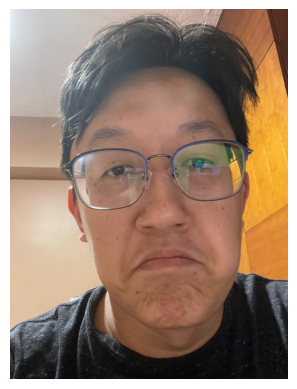

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt

# Display the image
def show_image(image_path):
    image = Image.open(image_path).convert('RGB')
    plt.imshow(image)
    plt.axis('off')  # Hide the axes
    plt.show()

show_image(image_path)  # Show the image

Predict the new photo

In [ ]:
# Define class names (update these if your dataset has different classes)
class_names = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']

# Make a prediction
with torch.no_grad():
    outputs = model(image)
    _, predicted = torch.max(outputs, 1)

# Print the predicted class
predicted_class = class_names[predicted.item()]
print(f'Predicted class: {predicted_class}')

Predicted class: angry
